In [1]:
!pip install -U tensorflow==2.8 wandb==0.16

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 30.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  At

## Enable w&b logging

In [2]:
import wandb
wandb.login(key="fd9f24c89ea44085597d8689ee2472b1a6261015")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
config={
    "architecture": "Multimodal-Both",
    "input_shape": (32, 32, 3),
    "epochs": 50,
    "batch_size": 32,
    "seed": 44,
    "use_small_sample": False,
}

In [4]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ai-detection",

    # track hyperparameters and run metadata with wandb.config
    config=config
)

wandb: Currently logged in as: m-lechow13 (budalema). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240701_005505-yg3cv4vj
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run royal-glade-113
wandb: ⭐️ View project at https://wandb.ai/budalema/ai-detection
wandb: 🚀 View run at https://wandb.ai/budalema/ai-detection/runs/yg3cv4vj


## Set seed for reproducability

In [5]:
import numpy as np
import tensorflow as tf

SEED = config["seed"]

# Set random seed for NumPy
np.random.seed(SEED)

# Set random seed for TensorFlow
tf.random.set_seed(SEED)

In [6]:
import os

print(os.listdir("/kaggle/input"))

['cifake-real-and-ai-generated-synthetic-images', 'cifake-rgb-radiomic-features']


## Import data

In [7]:
image_path_train = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train"

IMAGE_SIZE = (config["input_shape"][0], config["input_shape"][1])
BATCH_SIZE = None # do not batch - we want to perform shuffle

image_dataset_train = tf.keras.utils.image_dataset_from_directory(
    directory=image_path_train,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    label_mode='categorical',
#     subset='training',
#     validation_split=0.1,
    seed=config["seed"],
    shuffle=False
)

# validation_dataset = tf.keras.utils.image_dataset_from_directory(
#     directory=image_path_train,
#     batch_size=BATCH_SIZE,
#     image_size=IMAGE_SIZE,
#     label_mode='categorical',
#     subset='validation',
#     validation_split=0.1,
#     seed=config["seed"],
# )

image_path_test = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test"

image_dataset_test = tf.keras.utils.image_dataset_from_directory(
    directory=image_path_test,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    label_mode='categorical',
    shuffle=False,
)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


In [8]:
# Get the class encoding from the generator
class_encoding = image_dataset_train.class_names

# Print the class encoding
print("Class Encoding:", class_encoding)

Class Encoding: ['FAKE', 'REAL']


In [9]:
import pandas as pd
df = pd.read_csv("/kaggle/input/cifake-rgb-radiomic-features/RGB_train_features.csv", index_col=0)
df_test = pd.read_csv("/kaggle/input/cifake-rgb-radiomic-features/RGB_test_features.csv", index_col=0)

In [10]:
def drop_columns(df, drop_only_diagnostic=False):
    for column in df.columns:
        if df[column].min() == df[column].max() and not drop_only_diagnostic:
            df.drop(column, axis=1, inplace=True)
        elif 'diagnostics' in column:
            df.drop(column, axis=1, inplace=True)
        elif 'Mask' in column:
            df.drop(column, axis=1, inplace=True)
            
def preprocess_dataset(df, **kwargs):
    # print indexes and image names of rows with NaN values
    nans = df[df.isnull().any(axis=1)]['Image'].apply(lambda x : x.split('/')[-1])
    if not nans.empty:
        print(f"Rows with NaN values:")
        print(nans)
    df.dropna(inplace=True)  
    drop_columns(df, **kwargs)
    
def unify_columns(base_columns, df):
    # drop columns that are not in base_columns
    to_drop = list()
    for column in df.columns:
        if column not in base_columns:
            to_drop.append(column)
            
    df.drop(to_drop, axis=1, inplace=True)

In [11]:
from sklearn.model_selection import train_test_split

preprocess_dataset(df, drop_only_diagnostic=True)
preprocess_dataset(df_test, drop_only_diagnostic=True)

X = df.drop('Category', axis=1)
y = df['Category']

Image = X['Image']
X = X.drop('Image', axis=1)

In [12]:
X.head()

,R_original_shape2D_Elongation,R_original_shape2D_MajorAxisLength,R_original_shape2D_MaximumDiameter,R_original_shape2D_MeshSurface,R_original_shape2D_MinorAxisLength,R_original_shape2D_Perimeter,R_original_shape2D_PerimeterSurfaceRatio,R_original_shape2D_PixelSurface,R_original_shape2D_Sphericity,R_original_firstorder_10Percentile,...,B_lbp-2D_gldm_LargeDependenceLowGrayLevelEmphasis,B_lbp-2D_gldm_LowGrayLevelEmphasis,B_lbp-2D_gldm_SmallDependenceEmphasis,B_lbp-2D_gldm_SmallDependenceHighGrayLevelEmphasis,B_lbp-2D_gldm_SmallDependenceLowGrayLevelEmphasis,B_lbp-2D_ngtdm_Busyness,B_lbp-2D_ngtdm_Coarseness,B_lbp-2D_ngtdm_Complexity,B_lbp-2D_ngtdm_Contrast,B_lbp-2D_ngtdm_Strength
0,1.0,36.932371,44.553339,1023.5,36.932371,126.828427,0.123916,1024.0,0.894195,-118.333224,...,8.6875,1.0,0.119792,0.119792,0.119792,0.0,1000000.0,0.0,0.0,0.0
1,1.0,36.932371,44.553339,1023.5,36.932371,126.828427,0.123916,1024.0,0.894195,-153.391086,...,8.6875,1.0,0.119792,0.119792,0.119792,0.0,1000000.0,0.0,0.0,0.0
2,1.0,36.932371,44.553339,1023.5,36.932371,126.828427,0.123916,1024.0,0.894195,-173.356861,...,8.6875,1.0,0.119792,0.119792,0.119792,0.0,1000000.0,0.0,0.0,0.0
3,1.0,36.932371,44.553339,1023.5,36.932371,126.828427,0.123916,1024.0,0.894195,-132.478270,...,8.6875,1.0,0.119792,0.119792,0.119792,0.0,1000000.0,0.0,0.0,0.0
4,1.0,36.932371,44.553339,1023.5,36.932371,126.828427,0.123916,1024.0,0.894195,-129.649860,...,8.6875,1.0,0.119792,0.119792,0.119792,0.0,1000000.0,0.0,0.0,0.0


In [13]:
non_float_columns = X.select_dtypes(exclude=['float']).columns
print(non_float_columns)

Index([], dtype='object')


In [14]:
X_tensor = tf.convert_to_tensor(X)
X_tensor = tf.expand_dims(X_tensor, axis=0)
X_tensor = tf.reshape(X_tensor, (-1, 1, X.shape[1]))
# tf.reshape(X_tensor, [32, tf.size(X_tensor[0])])
tabular_dataset = tf.data.Dataset.from_tensor_slices(X_tensor)

In [15]:
tabular_dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1, 2484), dtype=tf.float64, name=None)>

In [16]:
image_dataset_train

<PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2,), dtype=tf.float32, name=None))>

In [17]:
# Merge datasets
images = image_dataset_train.map(lambda x, y : x)
labels = image_dataset_train.map(lambda x, y : y)
joint_dataset = tf.data.Dataset.zip(((images, tabular_dataset), labels))
joint_dataset

<ZipDataset element_spec=((TensorSpec(shape=(32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1, 2484), dtype=tf.float64, name=None)), TensorSpec(shape=(2,), dtype=tf.float32, name=None))>

In [18]:
# Define the total size of your dataset
total_size = len(joint_dataset)

# Define the size of the validation set (e.g., 20%)
validation_size = int(0.1 * total_size)

# Shuffle the dataset
dataset_shuffled = joint_dataset.shuffle(buffer_size=total_size, seed=config["seed"])
dataset_shuffled = dataset_shuffled.batch(config["batch_size"])

# Define the total size of your dataset
total_size = len(dataset_shuffled)

# Define the size of the validation set (e.g., 20%)
validation_size = int(0.1 * total_size)

# Split the dataset into training and validation sets
validation_dataset = dataset_shuffled.take(validation_size)
train_dataset = dataset_shuffled.skip(validation_size)

print(int(train_dataset.cardinality()))
print(int(validation_dataset.cardinality()))

2813
312


## Load and show sample image

In [19]:
# Retrieve a batch of data from the generator
first_element = train_dataset.take(1)
first_element

<TakeDataset element_spec=((TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 2484), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

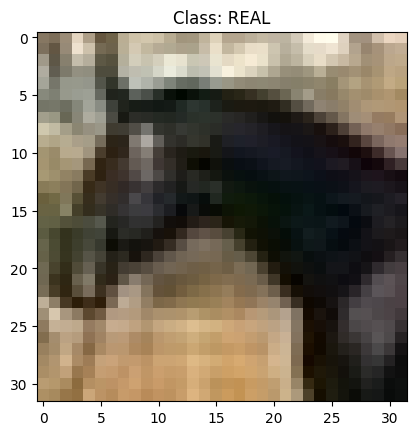

In [20]:
import matplotlib.pyplot as plt

# Extract images and labels from the first element
x, labels = next(iter(first_element))
images, tabular_data = x

plt.imshow(images[0].numpy().squeeze().astype("uint8"))
plt.title(f"Class: {image_dataset_train.class_names[labels[0].numpy().argmax()]}")
#     plt.axis('off')
plt.show()

In [21]:
labels

<tf.Tensor: shape=(32, 2), dtype=float32, numpy=
array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)>

In [22]:
tabular_data

<tf.Tensor: shape=(32, 1, 2484), dtype=float64, numpy=
array([[[ 1.        , 36.93237063, 44.55333882, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 1.        , 36.93237063, 44.55333882, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 1.        , 36.93237063, 44.55333882, ...,  0.        ,
          0.        ,  0.        ]],

       ...,

       [[ 1.        , 36.93237063, 44.55333882, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 1.        , 36.93237063, 44.55333882, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 1.        , 36.93237063, 44.55333882, ...,  0.        ,
          0.        ,  0.        ]]])>

In [23]:
norm = tf.keras.layers.Normalization()
norm.adapt(tabular_data)

In [24]:
from tensorflow.keras import layers

NUMBER_OF_CLASSES = 2

# Image part
img_input = layers.Input(shape=config["input_shape"], name='img_input')

img_X = layers.Conv2D(64, (3, 3))(img_input)
img_X = layers.BatchNormalization()(img_X)
img_X = layers.ReLU()(img_X)

img_output = layers.Flatten()(img_X)

# Radiomic part
tabular_input = layers.Input(shape=tuple(tabular_data.shape[1:]), name='tabular_input')
# tabular_X = norm(tabular_input)
tabular_X = layers.Flatten()(img_input)

tabular_X = layers.Dense(32)(tabular_X)
tabular_X = layers.BatchNormalization()(tabular_X)
tabular_X = layers.ReLU()(tabular_X)

tabular_X = layers.Dropout(0.3)(tabular_X)

tabular_X = layers.Dense(16)(tabular_X)
tabular_X = layers.BatchNormalization()(tabular_X)
tabular_X = layers.ReLU()(tabular_X)

tabular_output = layers.Flatten()(tabular_X)

# Combine
combined = layers.Concatenate()([img_output, tabular_output])

# output
output = layers.Dense(NUMBER_OF_CLASSES, activation='softmax')(combined)

# define model
keras_model = tf.keras.Model(inputs=[img_input, tabular_input], outputs=output)

keras_model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 3072)         0           ['img_input[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 32)           98336       ['flatten_1[0][0]']              
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 32)          128         ['dense[0][0]']                  
 rmalization)                                                                                 

In [25]:
keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Train the model

In [26]:
from wandb.keras import WandbCallback

EPOCHS = config["epochs"]

if config["use_small_sample"] is True:
    steps_per_epoch = 1000 // BATCH_SIZE
    validation_steps = 100 // BATCH_SIZE
else:
    # train_dataset.samples // BATCH_SIZE
    steps_per_epoch = None
    validation_steps = None
    
print(f"steps_per_epoch = {steps_per_epoch}, validation_steps = {validation_steps}\n\n")
    
history = keras_model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=[
      WandbCallback(),
    ],
    validation_steps=validation_steps
)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


steps_per_epoch = None, validation_steps = None


Epoch 1/50
2812/2813 [============================>.] - ETA: 0s - loss: 1.0515 - accuracy: 0.7776

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240701_005505-yg3cv4vj/files/model-best)... Done. 0.0s


2813/2813 [==============================] - 201s 57ms/step - loss: 1.0513 - accuracy: 0.7776 - val_loss: 1.1924 - val_accuracy: 0.6998
Epoch 2/50
2813/2813 [==============================] - ETA: 0s - loss: 0.3367 - accuracy: 0.8735

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240701_005505-yg3cv4vj/files/model-best)... Done. 0.1s


2813/2813 [==============================] - 192s 54ms/step - loss: 0.3367 - accuracy: 0.8735 - val_loss: 0.2857 - val_accuracy: 0.8836
Epoch 3/50
2813/2813 [==============================] - 190s 53ms/step - loss: 0.2641 - accuracy: 0.8956 - val_loss: 0.5191 - val_accuracy: 0.8035
Epoch 4/50
2813/2813 [==============================] - ETA: 0s - loss: 0.2447 - accuracy: 0.9034

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240701_005505-yg3cv4vj/files/model-best)... Done. 0.0s


2813/2813 [==============================] - 208s 58ms/step - loss: 0.2447 - accuracy: 0.9034 - val_loss: 0.1906 - val_accuracy: 0.9257
Epoch 5/50
2813/2813 [==============================] - ETA: 0s - loss: 0.2325 - accuracy: 0.9089

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240701_005505-yg3cv4vj/files/model-best)... Done. 0.0s


2813/2813 [==============================] - 219s 62ms/step - loss: 0.2325 - accuracy: 0.9089 - val_loss: 0.1900 - val_accuracy: 0.9225
Epoch 6/50
2813/2813 [==============================] - 189s 52ms/step - loss: 0.2176 - accuracy: 0.9148 - val_loss: 0.3309 - val_accuracy: 0.8700
Epoch 7/50
2813/2813 [==============================] - 207s 55ms/step - loss: 0.2034 - accuracy: 0.9214 - val_loss: 0.1967 - val_accuracy: 0.9176
Epoch 8/50
2813/2813 [==============================] - 194s 54ms/step - loss: 0.1928 - accuracy: 0.9248 - val_loss: 0.5298 - val_accuracy: 0.8062
Epoch 9/50
2813/2813 [==============================] - ETA: 0s - loss: 0.1844 - accuracy: 0.9287

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240701_005505-yg3cv4vj/files/model-best)... Done. 0.1s


2813/2813 [==============================] - 205s 57ms/step - loss: 0.1844 - accuracy: 0.9287 - val_loss: 0.1434 - val_accuracy: 0.9446
Epoch 10/50
2813/2813 [==============================] - 205s 53ms/step - loss: 0.1763 - accuracy: 0.9317 - val_loss: 0.2768 - val_accuracy: 0.8985
Epoch 11/50
2813/2813 [==============================] - 200s 56ms/step - loss: 0.1673 - accuracy: 0.9345 - val_loss: 0.2205 - val_accuracy: 0.9083
Epoch 12/50
2813/2813 [==============================] - 197s 54ms/step - loss: 0.1593 - accuracy: 0.9374 - val_loss: 0.1606 - val_accuracy: 0.9336
Epoch 13/50
2813/2813 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.9405

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240701_005505-yg3cv4vj/files/model-best)... Done. 0.0s


2813/2813 [==============================] - 223s 62ms/step - loss: 0.1526 - accuracy: 0.9405 - val_loss: 0.1392 - val_accuracy: 0.9460
Epoch 14/50
2813/2813 [==============================] - ETA: 0s - loss: 0.1474 - accuracy: 0.9423

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240701_005505-yg3cv4vj/files/model-best)... Done. 0.0s


2813/2813 [==============================] - 197s 55ms/step - loss: 0.1474 - accuracy: 0.9423 - val_loss: 0.1154 - val_accuracy: 0.9553
Epoch 15/50
2813/2813 [==============================] - 191s 52ms/step - loss: 0.1410 - accuracy: 0.9460 - val_loss: 0.3475 - val_accuracy: 0.8757
Epoch 16/50
2813/2813 [==============================] - 207s 59ms/step - loss: 0.1362 - accuracy: 0.9463 - val_loss: 0.2293 - val_accuracy: 0.9082
Epoch 17/50
2813/2813 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.9480

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240701_005505-yg3cv4vj/files/model-best)... Done. 0.0s


2813/2813 [==============================] - 203s 56ms/step - loss: 0.1351 - accuracy: 0.9480 - val_loss: 0.1035 - val_accuracy: 0.9619
Epoch 18/50
2813/2813 [==============================] - 191s 53ms/step - loss: 0.1253 - accuracy: 0.9508 - val_loss: 0.1120 - val_accuracy: 0.9544
Epoch 19/50
2813/2813 [==============================] - 191s 53ms/step - loss: 0.1229 - accuracy: 0.9521 - val_loss: 0.1564 - val_accuracy: 0.9400
Epoch 20/50
2813/2813 [==============================] - ETA: 0s - loss: 0.1204 - accuracy: 0.9526

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240701_005505-yg3cv4vj/files/model-best)... Done. 0.0s


2813/2813 [==============================] - 192s 53ms/step - loss: 0.1204 - accuracy: 0.9526 - val_loss: 0.0939 - val_accuracy: 0.9662
Epoch 21/50
2813/2813 [==============================] - 198s 55ms/step - loss: 0.1185 - accuracy: 0.9537 - val_loss: 0.1528 - val_accuracy: 0.9358
Epoch 22/50
2813/2813 [==============================] - 192s 54ms/step - loss: 0.1131 - accuracy: 0.9561 - val_loss: 0.1067 - val_accuracy: 0.9587
Epoch 23/50
2812/2813 [============================>.] - ETA: 0s - loss: 0.1090 - accuracy: 0.9581

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240701_005505-yg3cv4vj/files/model-best)... Done. 0.0s


2813/2813 [==============================] - 197s 55ms/step - loss: 0.1089 - accuracy: 0.9581 - val_loss: 0.0774 - val_accuracy: 0.9697
Epoch 24/50
2813/2813 [==============================] - 190s 53ms/step - loss: 0.1100 - accuracy: 0.9577 - val_loss: 0.1344 - val_accuracy: 0.9465
Epoch 25/50
2813/2813 [==============================] - 187s 51ms/step - loss: 0.1037 - accuracy: 0.9597 - val_loss: 0.4497 - val_accuracy: 0.8424
Epoch 26/50
2813/2813 [==============================] - 192s 54ms/step - loss: 0.1031 - accuracy: 0.9603 - val_loss: 0.1747 - val_accuracy: 0.9250
Epoch 27/50
2813/2813 [==============================] - 189s 52ms/step - loss: 0.0981 - accuracy: 0.9621 - val_loss: 0.1141 - val_accuracy: 0.9563
Epoch 28/50
2813/2813 [==============================] - 194s 53ms/step - loss: 0.0988 - accuracy: 0.9617 - val_loss: 0.2003 - val_accuracy: 0.9236
Epoch 29/50
2813/2813 [==============================] - 187s 52ms/step - loss: 0.0972 - accuracy: 0.9623 - val_loss: 0.1576

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240701_005505-yg3cv4vj/files/model-best)... Done. 0.1s


2813/2813 [==============================] - 195s 54ms/step - loss: 0.0850 - accuracy: 0.9676 - val_loss: 0.0602 - val_accuracy: 0.9784
Epoch 37/50
2813/2813 [==============================] - 188s 52ms/step - loss: 0.0845 - accuracy: 0.9676 - val_loss: 0.5192 - val_accuracy: 0.8363
Epoch 38/50
2813/2813 [==============================] - 190s 52ms/step - loss: 0.0810 - accuracy: 0.9700 - val_loss: 0.1722 - val_accuracy: 0.9266
Epoch 39/50
2813/2813 [==============================] - 191s 53ms/step - loss: 0.0807 - accuracy: 0.9693 - val_loss: 0.1355 - val_accuracy: 0.9497
Epoch 40/50
2813/2813 [==============================] - 194s 53ms/step - loss: 0.0801 - accuracy: 0.9695 - val_loss: 0.2239 - val_accuracy: 0.9277
Epoch 41/50
2813/2813 [==============================] - 198s 56ms/step - loss: 0.0776 - accuracy: 0.9704 - val_loss: 0.0676 - val_accuracy: 0.9744
Epoch 42/50
2813/2813 [==============================] - 198s 53ms/step - loss: 0.0784 - accuracy: 0.9692 - val_loss: 0.1662

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240701_005505-yg3cv4vj/files/model-best)... Done. 0.0s


2813/2813 [==============================] - 199s 55ms/step - loss: 0.0755 - accuracy: 0.9717 - val_loss: 0.0516 - val_accuracy: 0.9814
Epoch 45/50
2813/2813 [==============================] - 194s 54ms/step - loss: 0.0724 - accuracy: 0.9727 - val_loss: 0.0584 - val_accuracy: 0.9755
Epoch 46/50
2813/2813 [==============================] - 190s 52ms/step - loss: 0.0751 - accuracy: 0.9715 - val_loss: 0.0674 - val_accuracy: 0.9743
Epoch 47/50
2813/2813 [==============================] - 207s 53ms/step - loss: 0.0730 - accuracy: 0.9721 - val_loss: 0.0517 - val_accuracy: 0.9792
Epoch 48/50
2813/2813 [==============================] - 193s 52ms/step - loss: 0.0708 - accuracy: 0.9730 - val_loss: 0.0707 - val_accuracy: 0.9720
Epoch 49/50
2813/2813 [==============================] - 197s 54ms/step - loss: 0.0715 - accuracy: 0.9729 - val_loss: 0.0591 - val_accuracy: 0.9765
Epoch 50/50
2813/2813 [==============================] - ETA: 0s - loss: 0.0695 - accuracy: 0.9734

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240701_005505-yg3cv4vj/files/model-best)... Done. 0.0s


2813/2813 [==============================] - 202s 55ms/step - loss: 0.0695 - accuracy: 0.9734 - val_loss: 0.0454 - val_accuracy: 0.9837


In [27]:
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:     accuracy ▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
wandb:        epoch ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:         loss █▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: val_accuracy ▁▆▄▇▅▆▄▇▆▇▇▇▆▇▇▇▇▇█▇▇▇▇▇▇▅▇██▄▇▇█▇▇█████
wandb:     val_loss █▂▄▂▃▂▄▂▂▂▂▁▂▁▁▂▂▁▁▂▂▁▂▂▁▃▂▁▁▄▂▂▁▂▂▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:      accuracy 0.97342
wandb:    best_epoch 49
wandb: best_val_loss 0.04536
wandb:         epoch 49
wandb:          loss 0.0695
wandb:  val_accuracy 0.98367
wandb:      val_loss 0.04536
wandb: 
wandb: 🚀 View run royal-glade-113 at: https://wandb.ai/budalema/ai-detection/runs/yg3cv4vj
wandb: Synced 6 W&B file(s), 1 media file(s), 52 artifact file(s) and 1 other file(s)
wandb: Find logs at: ./wandb/run-20240701_005505-yg3cv4vj/logs
